In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
# import dataset into a pandas data frame

df = pd.read_csv('../41467_2022_32829_MOESM5_ESM.csv')
df.head()

,ID,DNA1 [counts],DNA2 [counts],DNA3 [counts],RNA1 [counts],RNA2 [counts],RNA3 [counts],TX1 [au],TX2 [au],TX3 [au],...,high quality,Observed log(TX/Txref),Predicted log(TX/Txref),dG10,dG35,dGDisc,dGITR,dGEXT10,dGSPAC,dGUP
0,0,8263,7261,5173,16341,10320,13506,2.258071,1.523795,1.545541,...,Yes,-3.386326,-3.844827,-1.781524,-1.477218,-0.106428,-0.021112,0.191352,-0.0924,0.400862
1,1,5600,4886,3264,10986,7250,10800,2.240001,1.590845,1.958709,...,Yes,-3.503140,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
2,2,7898,6790,4752,19572,32204,30585,2.829533,5.084911,3.810029,...,Yes,-4.207206,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
3,3,10651,9875,6466,15734,16246,18908,1.686729,1.763814,1.731036,...,Yes,-3.392439,-3.877808,-1.781524,-1.477218,-0.139409,-0.021112,0.191352,-0.0924,0.400862
4,4,12188,10793,6965,28609,21796,26803,2.680198,2.165100,2.278025,...,Yes,-3.698903,-3.672384,-1.781524,-1.477218,0.066015,-0.021112,0.191352,-0.0924,0.400862


In [4]:
# All input and output data

X = df['Observed log(TX/Txref)']
y = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]

y.head()

,UP,h35,spacs,h10,disc,ITR
0,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CCCCGCGG,CTCTACCTTAGTTTGTACGTT
1,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGGCGG,CTCTACCTTAGTTTGTACGTT
2,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGCCCG,CTCTACCTTAGTTTGTACGTT
3,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,GCGGCGGC,CTCTACCTTAGTTTGTACGTT
4,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGGGGGGC,CTCTACCTTAGTTTGTACGTT


In [5]:
# remove all rows with spacer sequences that are not 16-18 nucleotides long


_df = df[(df['spacs'].str.len() >= 15) & (df['spacs'].str.len() <= 19)]


X = _df['Observed log(TX/Txref)']
y = _df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]

print(f'Removed {df.shape[0] - _df.shape[0]} rows')


Removed 140 rows


In [6]:
# Function to one-hot encode DNA sequences, including padding 0's

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

In [7]:
upstream_padding = {}

for col in y.columns:
    max_len = y[col].apply(len).max()
    upstream_padding[col] = np.array([padded_one_hot_encode('0' * (max_len - len(seq)) + seq) for seq in y[col]])

# Concatenate the doncatenated one-hot encoded, upstream-padded sequences
y = np.concatenate([upstream_padding[col] for col in y.columns], axis=1)

y = np.array([np.concatenate(each) for each in y])

In [8]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,

In [9]:
X[0]


-3.386326274

In [10]:
# split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [11]:
shape = y_train.shape[1]

# Repeat each floating-point number to match the length of its corresponding DNA sequence
repeated_X = np.repeat(X_train.values.reshape(-1, 1), 328, axis=1)

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.RepeatVector(shape),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),  # Adding another LSTM layer
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(shape, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - loss: 1.6529 - val_loss: 0.5392
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - loss: 0.5363 - val_loss: 0.5328
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 128s 426ms/step - loss: 0.5304 - val_loss: 0.5252
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 191s 587ms/step - loss: 0.5238 - val_loss: 0.5218
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 183s 608ms/step - loss: 0.5209 - val_loss: 0.5202
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 196s 587ms/step - loss: 0.5194 - val_loss: 0.5197
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 181s 516ms/step - loss: 0.5189 - val_loss: 0.5191
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 71s 235ms/step - loss: 0.5182 - val_loss: 0.5192
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - loss: 0.5183 - val_loss: 0.5189
Epoch 10/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 88s 292ms/step - loss: 0.5179 - val_loss: 0.5190
Epoch 11/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 73s 241ms/step - loss: 0.5180 - val_loss: 0.5188
Epoch 12/50
30

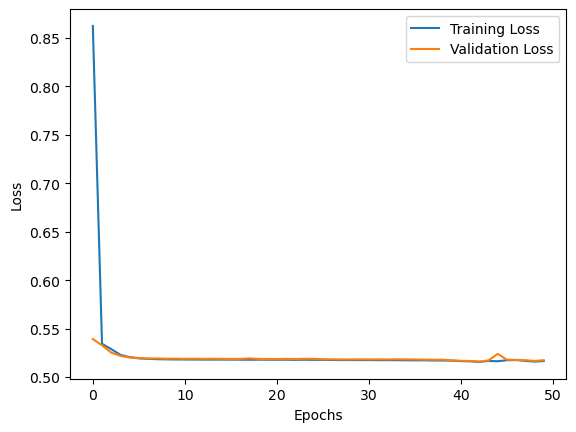

In [12]:
repeated_X_test = np.repeat(X_test.values.reshape(-1, 1), shape, axis=1)

# Define EarlyStopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history = model.fit(repeated_X, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
print(history.history['val_loss'])

[0.5392353534698486, 0.5327712297439575, 0.525227427482605, 0.5218371748924255, 0.520224928855896, 0.5197222232818604, 0.5191249251365662, 0.5192298293113708, 0.5189335346221924, 0.5189831256866455, 0.51880943775177, 0.5189354419708252, 0.5187929272651672, 0.5188749432563782, 0.51874840259552, 0.5186856985092163, 0.5187137126922607, 0.5192756056785583, 0.5187208652496338, 0.5186938047409058, 0.5185914039611816, 0.5187472701072693, 0.5186467170715332, 0.5188679695129395, 0.518783450126648, 0.5184208154678345, 0.5182842016220093, 0.5181983709335327, 0.5181719064712524, 0.5183208584785461, 0.5181885361671448, 0.5183125734329224, 0.5181635022163391, 0.5183436274528503, 0.5182814002037048, 0.5181214213371277, 0.5179652571678162, 0.5178297758102417, 0.5179238319396973, 0.5173046588897705, 0.5167660117149353, 0.5166142582893372, 0.5159708261489868, 0.5171639919281006, 0.5239402651786804, 0.5178656578063965, 0.5176881551742554, 0.5174257755279541, 0.5166182518005371, 0.5174041390419006]


In [14]:
# Repeat each floating-point number to match the length of its corresponding DNA sequence
repeated_X_test = np.repeat(X_test.values.reshape(-1, 1), shape, axis=1)

# Evaluate on test set
test_loss = model.evaluate(repeated_X_test, y_test)
print("Test Loss:", test_loss)

84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.5168
Test Loss: 0.5166512727737427


In [15]:
# save the model

model.save('initial_backward_pred.keras')